machine learning for texts

Необходимо обучить модель разделять комментарии на позитивные и негативные. Есть исходный набор данных с разметкой. Необходима модель со значением метрики качества *F1* не меньше 0.75. 

Порядок работы:
1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## 1 Подготовка

Необходимо скачать данные и провести предобработку.

In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from wordcloud import WordCloud

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from tqdm import notebook
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer 

In [ ]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [ ]:
data['toxic'].sum()

16225

In [ ]:
data.iloc[12, 0]

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

In [ ]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [ ]:
data.duplicated().sum()

0

In [ ]:
data['toxic'].unique()

array([0, 1])

# Вывод
Скачал данные. Пропусков, дубликатов и некорректных значений не обнаружено. В целевом признаке сильный дисбаланс - токсичных комментариев 16225 из 159570 что почти в десять раз меньше.

## 2 Обучение

Необходимо подготовить данные и обучить несколько моделей.

In [ ]:
data['text'] = data['text'].str.lower()

Приведение к нижнему регистру.

In [ ]:
def remove_whitespace(text):
    return  " ".join(text.split())


In [ ]:
data.iloc[11, 0]

'bbq \n\nbe a man and lets discuss it-maybe over the phone?'

In [ ]:
data['text'] = data['text'].apply(remove_whitespace)

In [ ]:
data.iloc[11, 0]

'bbq be a man and lets discuss it-maybe over the phone?'

In [ ]:
html_pattern = re.compile('<.*?>')
data['text'] = data.text.apply(lambda x: html_pattern.sub('', x))
data['text'] = data.text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [ ]:
data.iloc[11, 0]

'bbq be a man and lets discuss itmaybe over the phone'

In [ ]:
data.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,daww he matches this background colour im seem...,0
2,hey man im really not trying to edit war its j...,0
3,more i cant make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


Удалил лишние пробелы, знаки препинания и теги.

In [ ]:
lemmatizer = WordNetLemmatizer()
data['text'] = data.text.apply(lambda line: [lemmatizer.lemmatize(w) for w in line.split()])

In [ ]:
stop_words = set(nltk_stopwords.words('english') + ["there's"]) 
  
data['text'] = data.text.apply(lambda text: [w for w in text if not w in stop_words])

In [ ]:
data

,text,toxic
0,"[explanation, edits, made, username, hardcore,...",0
1,"[daww, match, background, colour, im, seemingl...",0
2,"[hey, man, im, really, trying, edit, war, guy,...",0
3,"[cant, make, real, suggestion, improvement, wo...",0
4,"[sir, hero, chance, remember, page, thats]",0
...,...,...
159566,"[second, time, asking, view, completely, contr...",0
159567,"[ashamed, horrible, thing, put, talk, page, 12...",0
159568,"[spitzer, umm, actual, article, prostitution, ...",0
159569,"[look, like, wa, actually, put, speedy, first,...",0


Лемматизировал и удалил стоп-слова.

In [ ]:
def frequent_words(df, col):
    
    lst=[]
    for text_collection in df[col]:
      lst+=text_collection
        
    fdist=FreqDist(lst)
    return fdist

fdist = frequent_words(data, 'text')

In [ ]:
fdist.most_common(10)

[('article', 72882),
 ('page', 56410),
 ('wa', 54510),
 ('wikipedia', 35526),
 ('ha', 31347),
 ('talk', 31185),
 ('one', 29878),
 ('please', 29599),
 ('would', 29207),
 ('like', 28125)]

Проверил наиболее часто встречающиеся слова. Паразитов, бессмысленных слов и прочего не обнаружил. Подготовка текста проведена корректно.

In [ ]:
X = data['text'].apply(lambda x: ' '.join(x))
Y = data['toxic']

In [ ]:
X_tr, X_te, Y_tr, Y_te = train_test_split(X, Y, test_size=0.2, random_state=12345)

In [ ]:
count_tf_idf = TfidfVectorizer(max_features=50000, min_df=2)
X_tr = count_tf_idf.fit_transform(X_tr)
X_te = count_tf_idf.transform(X_te)

Векторизировал слова. Подготовил обучающую и тестовую выборки.

In [ ]:
model_l_r = LogisticRegression(C=1e2, n_jobs=4, solver='lbfgs', random_state=123, verbose=0, fit_intercept=True, class_weight="auto")
cross_l_r = cross_val_score(model_l_r, X_tr, Y_tr, scoring = 'f1', cv=4)

f1_l_r = cross_l_r.mean()
print(f'f1 линейной регрессии:{f1_l_r}')
model_l_r.fit(X_tr, Y_tr)

f1 линейной регрессии:0.7523880127725


LogisticRegression(C=100.0, class_weight='auto', n_jobs=4, random_state=123)

In [ ]:
r_f_c = RandomForestClassifier(class_weight="balanced")
parametrs = { 'max_depth': (4, 6, 8, 10, 13),
              'min_samples_leaf': (1, 2, 3, 4, 5, 6, 7, 8),
              'min_samples_split': (2, 3, 4, 5, 6, 7, 8, 9, 10)}
serch_r_f_c = BayesSearchCV(r_f_c, parametrs, scoring = 'f1', cv=4, n_iter = 12)
serch_r_f_c.fit(X_tr, Y_tr)
f1_r_f_c = serch_r_f_c.best_score_
print(f'f1 случайного леса:{f1_r_f_c}')

f1 случайного леса:0.3939140011456393


# Вывод
Удалил знаки препинания, лемматизировал и векторизировал тексты. Разделил на обучающую и тестовую выборки. На обучающих выборках обучил модели линейной регрессии и случайного леса. F1-мера логистической регрессии достигла целевого значения 0.75.

# 3 Выводы

Необходимо сделать вывод.

In [ ]:
print('F1-мера логистической регрессии на тестовой выборке:', f1_score(Y_te, model_l_r.predict(X_te)))

F1-мера логистической регрессии на тестовой выборке: 0.7681945128963364


In [ ]:
print('roc-auc логистической регрессии на тестовой выборке:', roc_auc_score(Y_te, model_l_r.predict_proba(X_te)[:,1]))

roc-auc логистической регрессии на тестовой выборке: 0.9571221475125032


In [ ]:
df_toxic = data[data['toxic'] == 1]
df_not_toxic = data[data['toxic'] == 0]

<function matplotlib.pyplot.show>

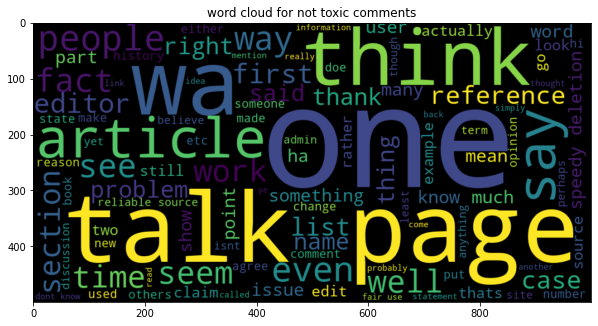

In [ ]:
plt.figure(figsize=(10,10))
positive_text = ' '.join(df_not_toxic['text'].apply(lambda x: ' '.join(x)))
WC=WordCloud(width=1000,height=500,max_words=100,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words, interpolation='bilinear')
plt.title('word cloud for not toxic comments')
plt.show

<function matplotlib.pyplot.show>

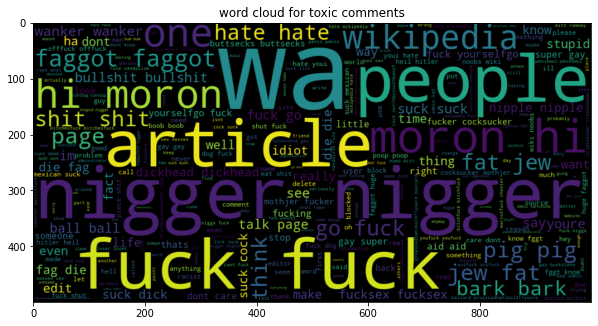

In [ ]:
plt.figure(figsize=(10,10))
positive_text = ' '.join(df_toxic['text'].apply(lambda x: ' '.join(x)))
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words, interpolation='bilinear')
plt.title('word cloud for toxic comments')
plt.show

#  Вывод

На тестовой выборке подтвердил что F1-мера превосходит целевое значение. Дополнительно посчитал roc_auc и вывел облака слов для токсичных и не токсичных комментариев

#  Общий вывод проекта
Обучил модель для распознавания токсичных комментариев. 
Исходные данные требуют трудоёмкой предобработки и дают в результате большое количество признаков. Лучшие результаты показала логистическая регрессия с F1-мерой на тестовой выборке - 0.768, что больше целевого значения 0.75.